In [38]:
try:
    import librosa
except:
    !pip install librosa
    !pip install matplotlib

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

# Plotting Waveform of a track

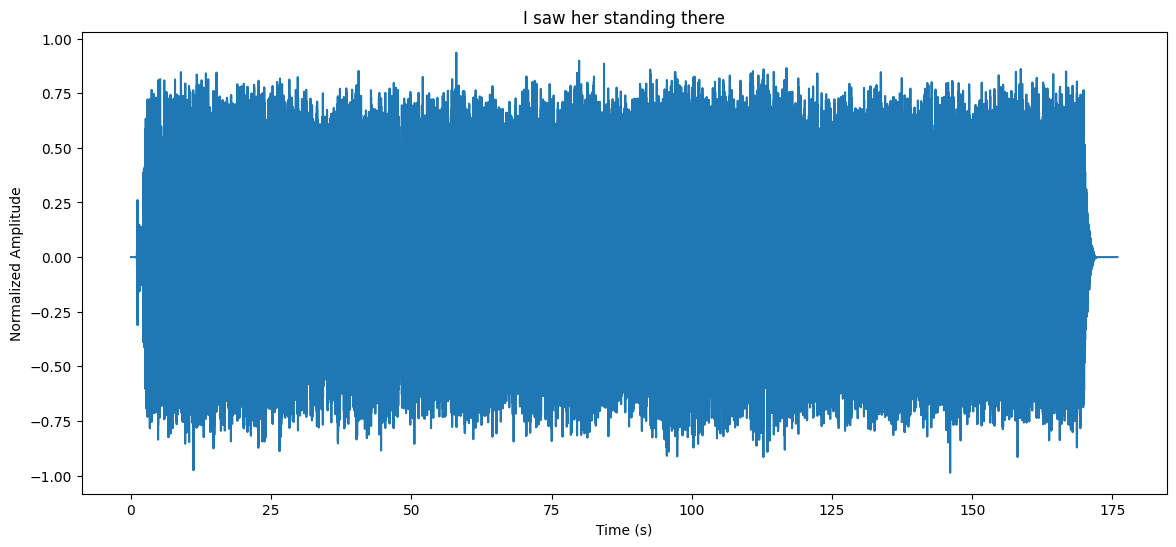

In [2]:
audio_file = "/home/aitha/thanos/audio/TheBeatles/01_-_Please_Please_Me/01_-_I_Saw_Her_Standing_There.wav"
y, sr = librosa.load(audio_file, sr=44100, mono=True)
# fig, ax = librosa.display.waveshow(y, sr=sr)

# get timestamps via sampling rate
times = [sample/sr for sample in range(len(y))]

plt.figure(figsize=(14,6))
plt.plot(times, y)
plt.title("I saw her standing there")

plt.ylabel('Normalized Amplitude')
plt.xlabel('Time (s)')
plt.show()

# Fourier transforms

## MFCC

In [3]:
def get_mfcc(data, sr, n_mfcc):
    '''Gets mfccs given a array like data structure and its sampling rates
    '''
    mfccs = []

    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc).T
        
    return mfcc

In [4]:
mfcc = get_mfcc(y, sr, 13)
# max_length = len(max(mfccs, key=len))

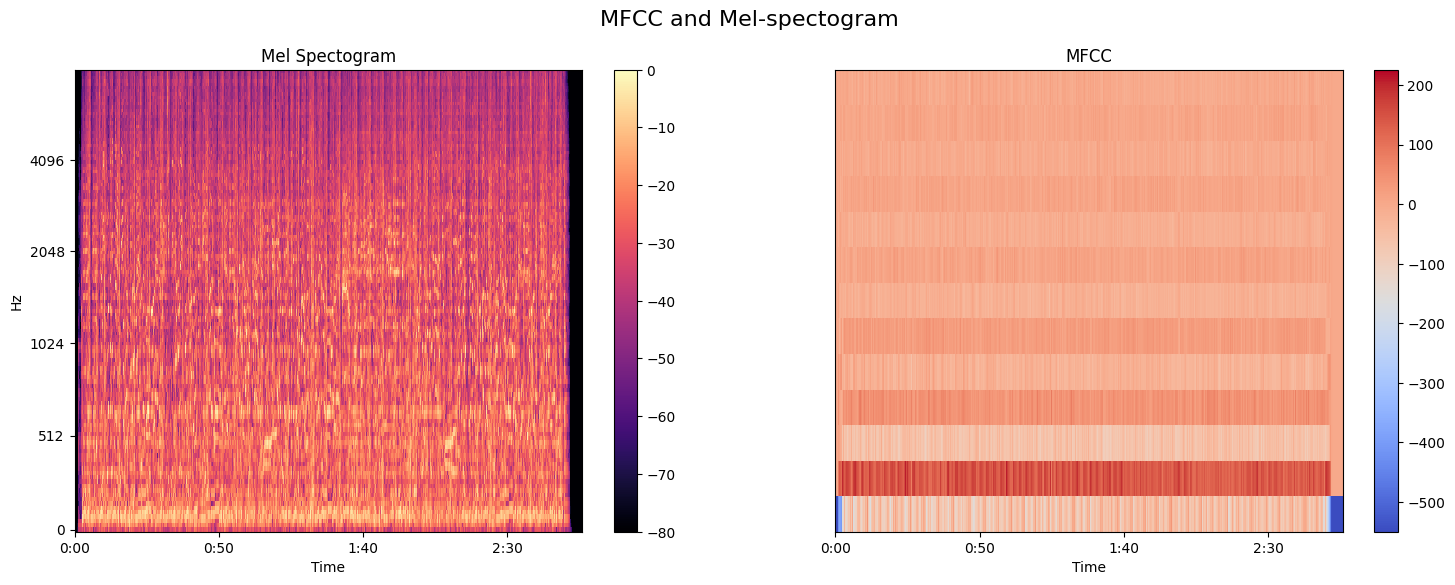

In [5]:
fig, ax = plt.subplots(1,2, figsize=(18,6), sharex=True)
    
# Get mel-spectogram as well
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                               fmax=8000)

# Plot mel - spectogram
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr,
                           x_axis='time', y_axis='mel', fmax=8000,
                           ax=ax[0])
ax[0].set(title = "Mel Spectogram")
fig.colorbar(img, ax=ax[0])

# Plot MFCC
img = librosa.display.specshow(mfcc.T, x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title = 'MFCC')

fig.colorbar(img, ax=ax[1])

fig.suptitle('MFCC and Mel-spectogram', fontsize=16)
plt.show()

In [35]:
print(mfcc.shape)

(15150, 13)


## STFT

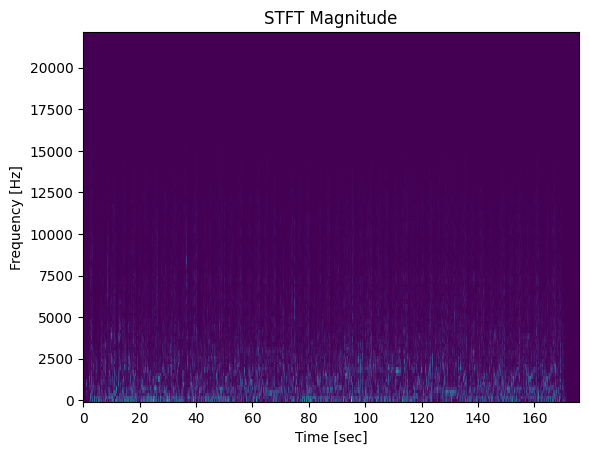

In [19]:
f, t, Zxx = scipy.signal.stft(y, fs=44100, return_onesided=True)

plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [34]:
print(Zxx.shape)

(129, 60598)


In [30]:
stft = librosa.feature.chroma_stft(y=y, sr=44100)

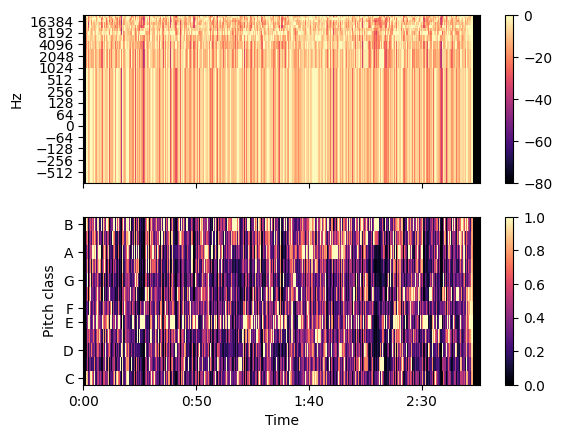

In [32]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max), sr=44100,
                               y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].label_outer()
img = librosa.display.specshow(stft, y_axis='chroma', x_axis='time', sr=44100, ax=ax[1])
fig.colorbar(img, ax=[ax[1]])

In [66]:
print(stft.shape)

(12, 15150)


# Labelling - adapting

In [58]:
label_path = "/home/aitha/thanos/TheBeatles_lab/01_-_Please_Please_Me/01_-_I_Saw_Her_Standing_There.lab"
label = pd.read_csv(label_path, delimiter=' ', names=['start', 'end', 'chord'])
print(label.head())

       start        end chord
0   0.000000   2.612267     N
1   2.612267  11.459070     E
2  11.459070  12.921927     A
3  12.921927  17.443474     E
4  17.443474  20.410362     B


In [92]:
label['end'].iloc[-1]

175.804082

In [118]:
def get_duration(time_labels):
    """returns duration of track"""
    
    return time_labels['end'].iloc[-1]

def get_timestep(duration, n_steps):
    """returns the duration of each time step"""
    
    return duration/n_steps
    
def adapt_labels(time_labels, n_steps):
    """transforms time based labels to frame based labels"""
    
    duration = get_duration(time_labels)
    timestamps = np.linspace(0, duration, num=n_steps)

    i = 0
    labels = []
    for timestamp in timestamps:
        if timestamp <= time_labels["end"][i]:
            labels.append((timestamp, time_labels["chord"][i]))
        else:
            i+=1
            labels.append((timestamp, time_labels["chord"][i]))
        
    return labels

In [119]:
adapted_labels = adapt_labels(label, stft.shape[1])
print(f'Frame 225: {adapted_labels[225]}')
# 225->226
print(f'Frame 226: {adapted_labels[226]}')

Frame 225: (2.611124064294673, 'N')
Frame 226: (2.6227290601359825, 'E')


In [125]:
class AdaptLabels:
    def __init__(self, label_path, n_steps):
        self.time_labels = pd.read_csv(label_path, delimiter=' ', names=['start', 'end', 'chord'])
        self.n_steps = n_steps
        self.duration = self.get_duration()
        self.timestep = self.get_timestep()
        self.timestamps = np.linspace(0, self.duration, num=n_steps)
        self.labels = self.adapt_labels()

    def get_duration(self):
        """returns duration of track"""
        
        return self.time_labels['end'].iloc[-1]
    
    def get_timestep(self):
        """returns the duration of each time step"""
        
        return self.duration/self.n_steps
        
    def adapt_labels(self):
        """transforms time based labels to frame based labels"""
    
        i = 0
        labels = []
        for timestamp in self.timestamps:
            if timestamp <= self.time_labels["end"][i]:
                labels.append((timestamp, self.time_labels["chord"][i]))
            else:
                i+=1
                labels.append((timestamp, self.time_labels["chord"][i]))
            
        return labels

In [130]:
label_path = "/home/aitha/thanos/TheBeatles_lab/01_-_Please_Please_Me/01_-_I_Saw_Her_Standing_There.lab"
adapted_labs = AdaptLabels(label_path, 15150)
adapted_labs.labels

[(0.0, 'N'),
 (0.011604995841309657, 'N'),
 (0.023209991682619315, 'N'),
 (0.034814987523928975, 'N'),
 (0.04641998336523863, 'N'),
 (0.05802497920654828, 'N'),
 (0.06962997504785795, 'N'),
 (0.0812349708891676, 'N'),
 (0.09283996673047726, 'N'),
 (0.10444496257178691, 'N'),
 (0.11604995841309657, 'N'),
 (0.12765495425440623, 'N'),
 (0.1392599500957159, 'N'),
 (0.15086494593702554, 'N'),
 (0.1624699417783352, 'N'),
 (0.17407493761964485, 'N'),
 (0.18567993346095452, 'N'),
 (0.19728492930226418, 'N'),
 (0.20888992514357382, 'N'),
 (0.2204949209848835, 'N'),
 (0.23209991682619313, 'N'),
 (0.2437049126675028, 'N'),
 (0.25530990850881247, 'N'),
 (0.2669149043501221, 'N'),
 (0.2785199001914318, 'N'),
 (0.29012489603274144, 'N'),
 (0.3017298918740511, 'N'),
 (0.3133348877153607, 'N'),
 (0.3249398835566704, 'N'),
 (0.33654487939798006, 'N'),
 (0.3481498752392897, 'N'),
 (0.3597548710805994, 'N'),
 (0.37135986692190903, 'N'),
 (0.38296486276321867, 'N'),
 (0.39456985860452837, 'N'),
 (0.406174